In [18]:
# Import necessary libraries for numerical computation, plotting, and progress tracking
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Set random seed for reproducibility of simulation results
RAND_SEED=2

In [19]:
# Configure matplotlib plotting parameters for publication-quality figures
# Sets consistent font sizes, family, and axis styling
plt.rcParams.update({
    'font.size': 16,          # Global default font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 16,     # Axis label font size
    'xtick.labelsize': 16,    # X-axis tick label font size
    'ytick.labelsize': 16,    # Y-axis tick label font size
    'legend.fontsize': 14,     # Legend font size

    "font.family": "Arial",       # Font family for all text
    "axes.linewidth": 1.5,        # Line width for axes
    "xtick.direction": "out",      # Tick direction (outward)
    "ytick.direction": "out",
})

## Phase Noise Simulation
**Simulation Parameters:**
- Time resolution: 1 μs
- Sampling rate: 1 MHz
- Simulation duration: 1 s
- Phase noise model: Brownian motion (Wiener process)

      phase speed       phase
Mean     0.000018   10.782723
Std      0.017453   10.239478
Var      0.000305  104.846902


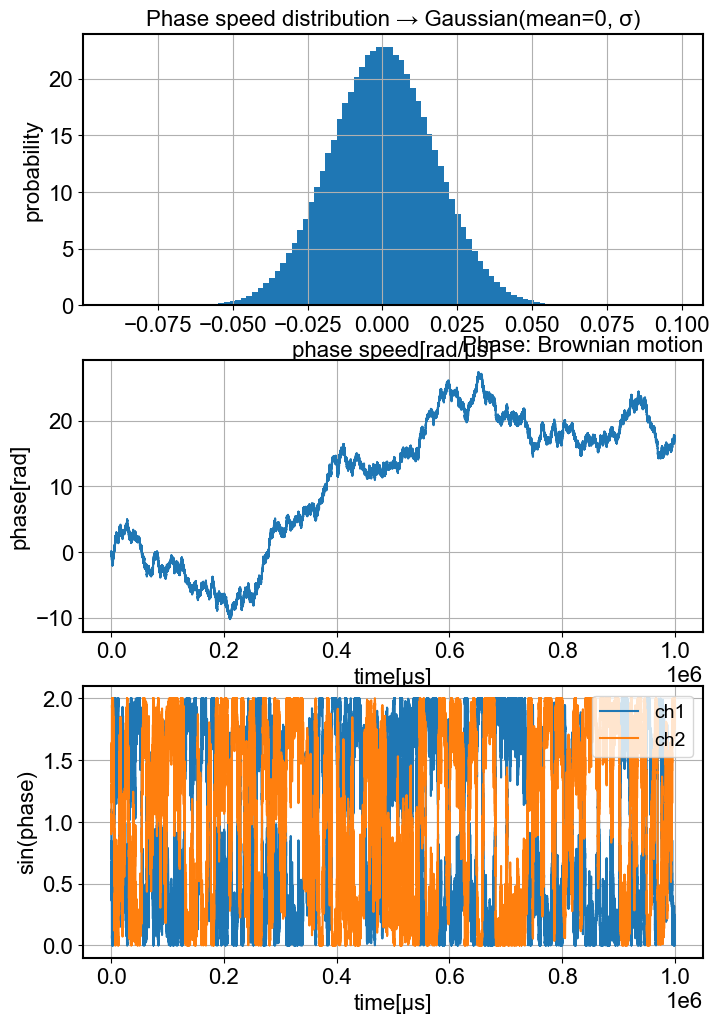

In [ ]:
# ============================================================================
# PHYSICAL PARAMETERS AND HELPER FUNCTIONS
# ============================================================================

# GAMMA: Background signal level (DC offset)
GAMMY=1.0

def get_phase_from_count(ch1, ch2):
    """
    Extract phase from photon counts in two channels.
    
    Uses the differential signal: (ch1 - ch2) / (ch1 + ch2) = sin(phase)
    This is based on the interference pattern where the phase difference
    creates a sinusoidal modulation between channels.
    
    Args:
        ch1: Photon count in channel 1
        ch2: Photon count in channel 2
    
    Returns:
        Phase in radians (via arcsin)
    """
    if ch1+ch2==0:
        return 0
    else:
        d = ((ch1-ch2)/(ch1+ch2))
        return np.arcsin(d)

def measure_count(sig):
    """
    Simulate photon counting measurement with shot noise.
    
    Shot noise follows Poisson statistics, where variance equals mean.
    This is the fundamental quantum noise in photon counting.
    
    Args:
        sig: Signal array (expected photon counts)
    
    Returns:
        Measured count with Poisson noise
    """
    # Introduce shot noise during measurement
    return rng.poisson(sig.sum())

def get_sig_from_speed(phase_speed, channel, Photon_Num=1, V=1):
    """
    Generate signal from phase speed (rate of phase change).
    
    Phase is obtained by cumulative sum of phase speed (integration).
    Signal in each channel is modulated by sin(phase) with opposite signs.
    
    Args:
        phase_speed: Array of phase speed values (rad/μs)
        channel: Channel number (1 or 2)
        Photon_Num: Total photon flux
        V: Visibility (modulation depth)
    
    Returns:
        Signal array for the specified channel
    """
    phase = np.cumsum(phase_speed)  # Integrate speed to get phase
    if channel==1:
        return Photon_Num*(GAMMY+V*np.sin(phase))
    elif channel==2:
        return Photon_Num*(GAMMY-V*np.sin(phase))

def get_sig_from_phase(phase, channel, Photon_Num=1, V=1):
    """
    Generate signal directly from phase values.
    
    Args:
        phase: Phase array in radians
        channel: Channel number (1 or 2)
        Photon_Num: Total photon flux
        V: Visibility (modulation depth)
    
    Returns:
        Signal array for the specified channel
    """
    if channel==1:
        return Photon_Num*(GAMMY+V*np.sin(phase))
    elif channel==2:
        return Photon_Num*(GAMMY-V*np.sin(phase))

# ============================================================================
# SIMULATION PARAMETERS
# ============================================================================

# PHASE_SEEPD: Standard deviation of phase speed (diffusion coefficient)
# Phase speed follows Gaussian distribution: N(0, PHASE_SEEPD^2)
PHASE_SEEPD = 1/180*np.pi  # rad/μs (equivalent to 1 degree/μs)

# SIG_AMP: Signal amplitude (photon flux per sample)
SIG_AMP = 1  # photons per μs

# Time axis: 1 μs resolution, 1 second duration, 1 MHz sampling rate
time_axis = np.arange(0, 1e6, 1)  # 1 μs resolution, length=1s, SR=1M

# Initialize random number generator for reproducibility
rng = np.random.default_rng(RAND_SEED)

# Generate phase speed as Gaussian white noise (Brownian motion increments)
phase_speed = rng.normal(0, PHASE_SEEPD, time_axis.shape)

# Integrate phase speed to get phase (cumulative sum = Wiener process)
phase = np.cumsum(phase_speed)

# Generate signals for both channels
sig_ch1 = get_sig_from_speed(phase_speed, 1)
sig_ch2 = get_sig_from_speed(phase_speed, 2)

# ============================================================================
# VISUALIZATION: Phase noise characteristics
# ============================================================================
plt.figure(figsize=(8,12))

# Plot 1: Phase speed distribution (should be Gaussian)
plt.subplot(3,1,1)
plt.hist(phase_speed, bins=100, density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/μs]')
plt.grid()

# Plot 2: Phase evolution (Brownian motion / Wiener process)
plt.subplot(3,1,2)
plt.plot(time_axis, phase)
plt.xlabel('time[μs]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion', loc='right')
plt.grid()

# Plot 3: Signal in both channels (sinusoidally modulated)
plt.subplot(3,1,3)
plt.plot(time_axis, sig_ch1, label='ch1')
plt.plot(time_axis, sig_ch2, label='ch2')
plt.xlabel('time[μs]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)

# ============================================================================
# STATISTICAL ANALYSIS
# ============================================================================
# Create DataFrame to store statistics
df = pd.DataFrame({
    'Mean': phase_speed.mean(),
    'Std': phase_speed.std(),
    'Var': phase_speed.var()
}, index=['phase speed']).T

def push_data(data, name):
    """
    Add statistical summary (mean, std, variance) to DataFrame.
    
    Args:
        data: Data array to analyze
        name: Name for the data column
    """
    df[name] = [data.mean(), data.std(), data.var()]
    print(df)

push_data(phase, 'phase')

**Note on Variance Evaluation:**
If phase noise satisfies independent random distribution, variance is a good metric because it scales linearly with time (number of samples). This is a key property of Brownian motion/Wiener processes.

**Feedback Strategy:**
Feedback is applied periodically every `time_exposure` interval. This is the measurement and correction cycle time.  

### Weighted Feedback Method

**Theory of Weighted Feedback:**

Since phase drift speed is a random variable following a global distribution, it has no temporal correlation - each moment's phase speed is independent and identically distributed (i.i.d.). Therefore, we can use weighted averaging to calculate the feedback amount.

**Challenges in Phase Estimation:**
1. **Measurement Noise (Shot Noise)**: The dominant noise source is shot noise from photon counting, which follows Poisson statistics. The noise magnitude is proportional to signal strength - stronger signals have larger noise.
2. **Finite Measurement Time**: Measurements are not instantaneous, so they cannot capture instantaneous phase drift changes, leading to deviations between measured and actual phase drift.

**Solution - Weighted Feedback:**
- Phase evolution is a Wiener process, where the rate of change follows a Gaussian distribution
- Phase change over a fixed time interval also follows a Gaussian distribution
- **Strategy**: Apply full feedback for phase changes within a confidence interval (e.g., 3σ), and partial feedback for outliers beyond this interval
- For a Gaussian distribution, values beyond 3σ occur with probability ~0.27%, so we treat these as anomalies and apply reduced feedback

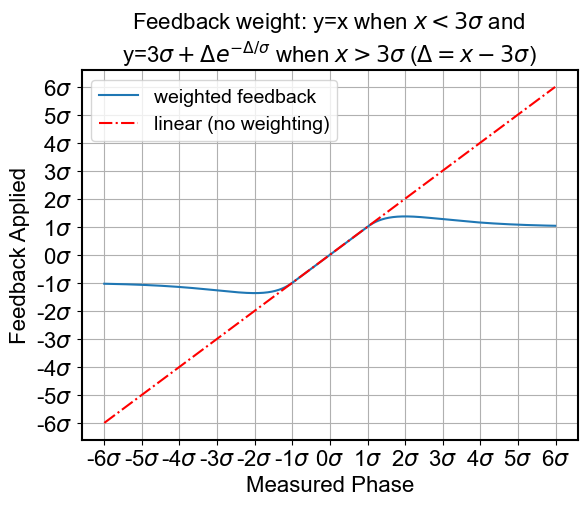

In [21]:
def fb_weight(measure, time_exposure, sigma=1):
    """
    Apply weighted feedback function to filter measurements.
    
    This function implements a robust feedback strategy:
    - For measurements within threshold (sigma * expected_std): linear feedback (y = x)
    - For outliers beyond threshold: exponential damping (y = threshold + Δ*exp(-Δ/σ))
      where Δ = |x| - threshold
    
    This prevents over-correction from measurement outliers while maintaining
    full feedback for normal fluctuations.
    
    Args:
        measure: Measured phase value (rad)
        time_exposure: Measurement time window (μs)
        sigma: Number of standard deviations for threshold (default: 1, typically 2-3)
    
    Returns:
        Filtered/weighted measurement value for feedback
    """
    # Expected standard deviation of phase change over measurement time
    # For Wiener process: std(Δφ) = sqrt(time) * diffusion_coefficient
    phase_speed_in_measure = np.sqrt(time_exposure) * PHASE_SEEPD / 1  # sigma
    
    # Threshold: sigma times the expected standard deviation
    threshold = sigma * phase_speed_in_measure
    
    # Weight function: exponential damping for outliers
    # For |x| > threshold: y = sign(x) * [threshold + (|x|-threshold)*exp(-(|x|-threshold)/σ)]
    weight = lambda x: np.sign(x) * (threshold + (np.abs(x) - threshold) * 
                                     np.exp(-(np.abs(x) - threshold) / phase_speed_in_measure))
    
    # Apply weight only to measurements beyond threshold
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure), measure)
    return measure_filtered

# ============================================================================
# VISUALIZATION: Feedback weight function
# ============================================================================
time_exposure = 100  # μs
phase_speed_in_measure = np.sqrt(time_exposure) * PHASE_SEEPD  # sigma

# Generate test values around ±3σ range
x = np.arange(-2, 2, 1/256) * 3 * phase_speed_in_measure

# Plot feedback function
plt.plot(x, fb_weight(x, time_exposure=time_exposure), label='weighted feedback')
plt.plot(x, x, 'r-.', label='linear (no weighting)')
plt.legend()
plt.grid()

# Format axes in units of sigma
plt.xticks(np.arange(-6, 7, 1) * 1 * phase_speed_in_measure,
           ['{}$\\sigma$'.format(i*1) for i in np.arange(-6, 7, 1)])
plt.yticks(np.arange(-6, 7, 1) * 1 * phase_speed_in_measure,
           ['{}$\\sigma$'.format(i*1) for i in np.arange(-6, 7, 1)])
plt.xlabel('Measured Phase')
plt.ylabel('Feedback Applied')
plt.title('Feedback weight: y=x when $x<3\\sigma$ and \n'
          'y=3$\\sigma+\\Delta e^{-\\Delta/\\sigma}$ when $x>3\\sigma$ '
          '($\\Delta =x-3\\sigma$)')
plt.show()

In [22]:
# ============================================================================
# PARAMETER RESET FOR MAIN SIMULATION
# ============================================================================
# Reset parameters for the comprehensive simulation study

# Time axis: 1 μs resolution, 1000 μs duration (1 ms total)
time_axis = np.arange(0, 1e3, 1)  # 1 μs resolution, length=1 ms, SR=1M

# Signal amplitude: photon flux per sample
SIG_AMP = 1  # photons per μs

# Phase diffusion speed: reduced for more stable simulation
PHASE_SEEPD = 0.01/180*np.pi  # rad/μs (0.01 degrees/μs)

# Random seed for reproducibility
RAND_SEED = 2025

In [23]:
def phase_stabilization(sig_ch1, sig_ch2, N, phase_speed, time_exposure, method):
    """
    Simulate phase stabilization using feedback control.
    
    This function implements a closed-loop feedback system:
    1. Divide time into exposure windows
    2. For each window:
       - Calculate phase evolution
       - Generate signals with shot noise
       - Measure phase from photon counts
       - Apply feedback correction to next window
    3. Return stabilized phase trajectory
    
    Args:
        sig_ch1: Signal array for channel 1 (placeholder, will be overwritten)
        sig_ch2: Signal array for channel 2 (placeholder, will be overwritten)
        N: Photon flux (photons per sample)
        phase_speed: Array of phase speed values (rad/μs)
        time_exposure: Measurement/correction window size (μs)
        method: Feedback method - "classical" or "ff" (weighted feedback)
    
    Returns:
        Stabilized phase array (rad)
    """
    # Reshape arrays into exposure windows (each row is one exposure period)
    sig_ch1_exposure = sig_ch1.reshape((-1, time_exposure))
    sig_ch2_exposure = sig_ch2.reshape((-1, time_exposure))
    phase_speed_M = np.copy(phase_speed.reshape((-1, time_exposure)))
    
    # Initialize arrays for phase and measurements
    phase_M = np.zeros_like(phase_speed_M)  # Phase within each exposure
    phase_measure_M = np.zeros(phase_speed_M.shape[0])  # Measured phase per exposure
    
    # Random number generator for shot noise
    rng = np.random.default_rng(RAND_SEED)
    
    # Phase offset: cumulative phase from previous exposures
    phase_offest = 0
    
    # Visibility: reduction due to phase diffusion during exposure
    # V = exp(-D*t/2) where D is diffusion coefficient
    Vis = np.exp(-PHASE_SEEPD**2 * time_exposure / 2)
    
    # Loop through each exposure window
    for i in range(sig_ch1_exposure.shape[0]):
        # Calculate phase evolution within this exposure (cumulative sum + offset)
        phase_M[i] = np.cumsum(phase_speed_M[i]) + phase_offest
        
        # Generate signals for both channels based on current phase
        sig_ch1_exposure[i] = get_sig_from_phase(phase_M[i], 1, Photon_Num=N, V=Vis)
        sig_ch2_exposure[i] = get_sig_from_phase(phase_M[i], 2, Photon_Num=N, V=Vis)
        
        # Introduce shot noise: Poisson statistics for photon counting
        ch1_measure = rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure = rng.poisson(sig_ch2_exposure[i].sum())
        
        # Extract phase from measured photon counts
        phase_measure_M[i] = get_phase_from_count(ch1_measure, ch2_measure)
        
        # Apply feedback correction to next exposure (if not last exposure)
        if i < (sig_ch1_exposure.shape[0] - 1):
            if method == "classical":
                # Classical method: direct feedback (no weighting)
                phase_speed_M[i+1, 0] -= phase_measure_M[i]  # Feedback to start of next exposure
            
            if method == "ff":
                # Weighted feedback method: apply filtering to reduce outlier impact
                c0 = fb_weight(phase_measure_M[i], time_exposure, sigma=2)
                phase_fb_M = np.sign(phase_measure_M[i]) * np.abs(c0)
                phase_speed_M[i+1, 0] -= phase_fb_M  # Weighted feedback to next exposure
        
        # Update phase offset for next iteration (carry over phase from end of current exposure)
        phase_offest = phase_M[i, -1]
    
    # Set first exposure to zero (initial condition)
    phase_speed_M[0, :] = np.zeros(time_exposure)
    
    # Calculate final phase by integrating corrected phase speeds
    phase_out_M = np.cumsum(phase_speed_M.reshape(-1))
    return phase_out_M.reshape(-1)

In [24]:
# ============================================================================
# PARAMETER SWEEP SETUP
# ============================================================================
# Define parameter ranges for comprehensive simulation study

# Photon flux: logarithmic range from 10 to 1000 photons per sample
n_dense = np.logspace(np.log10(10), np.log10(1000), 100)

# Phase diffusion speed: logarithmic range from 0.0001 to 0.1 degrees/μs
# Converted to rad/μs
phase_speed_list = np.logspace(np.log10(0.0001), np.log10(0.1), 100) / 180 * np.pi  # rad/μs

# Same ranges for theoretical calculations
n_theory_dense = np.logspace(np.log10(10), np.log10(1000), 100)
phase_speed_list_theory = np.logspace(np.log10(0.0001), np.log10(0.1), 100) / 180 * np.pi

# Initialize arrays to store results
# Rows: photon flux, Columns: phase speed
cla_std_array_theory = np.zeros([len(n_theory_dense), len(phase_speed_list_theory)])
ff_std_array_theory = np.zeros([len(n_theory_dense), len(phase_speed_list_theory)])

cla_std_array = np.zeros([len(n_dense), len(phase_speed_list)])
ff_std_array = np.zeros([len(n_dense), len(phase_speed_list)])

# ============================================================================
# THEORETICAL VARIANCE BOUNDS
# ============================================================================
def Prior_VarBound(x, b, c):
    """
    Theoretical variance bound for prior-assisted (weighted) feedback method.
    
    This formula accounts for:
    - Measurement noise (shot noise): b*x*exp(-c*x) term
    - Prior information: 1/(c*x + sqrt(c/b)) term
    - Phase diffusion: c*x term
    
    Args:
        x: Time exposure (μs)
        b: Photon flux parameter (2*N where N is photon flux)
        c: Phase diffusion coefficient squared (D^2)
    
    Returns:
        Theoretical variance bound
    """
    return 1/((b*x*np.exp(-c*x)) + 1/(c*x + np.sqrt(c/b))) + c*x

def VarBound(x, b, c):
    """
    Theoretical variance bound for classical feedback method.
    
    This formula accounts for:
    - Measurement noise (shot noise): b*x*exp(-c*x) term
    - Phase diffusion: c*x term
    
    Args:
        x: Time exposure (μs)
        b: Photon flux parameter (2*N where N is photon flux)
        c: Phase diffusion coefficient squared (D^2)
    
    Returns:
        Theoretical variance bound
    """
    return 1/((b*x*np.exp(-c*x))) + c*x

In [25]:
# ============================================================================
# PARAMETER SIMULATION
# ============================================================================
# Run simulations across all parameter combinations

RAND_SEED = 2025

# Initialize signal arrays (will be overwritten in each simulation)
sig_ch1 = np.zeros_like(time_axis)
sig_ch2 = np.zeros_like(time_axis)

# Loop through all parameter combinations
for i in tqdm(range(len(n_dense))):
    photon_flux = n_dense[i]  # Current photon flux
    
    for j in range(len(phase_speed_list)):
        ps = phase_speed_list[j]  # Current phase diffusion speed
        
        # Generate phase speed noise for this simulation
        # Each simulation uses a different random seed (j) for reproducibility
        rng = np.random.default_rng(0)
        phase_speed_dis = rng.normal(0, ps, time_axis.shape)
        
        # Run classical stabilization and compute standard deviation
        cla_std_array[i][j] = np.std(phase_stabilization(
            sig_ch1, sig_ch2, N=photon_flux, phase_speed=phase_speed_dis,
            time_exposure=100, method="classical"
        ))
        
        # Run weighted feedback stabilization and compute standard deviation
        ff_std_array[i][j] = np.std(phase_stabilization(
            sig_ch1, sig_ch2, N=photon_flux, phase_speed=phase_speed_dis,
            time_exposure=100, method="ff"
        ))
        
        # Calculate theoretical bounds
        # b = 2*photon_flux (factor of 2 from two channels)
        # c = ps^2 (phase diffusion coefficient squared)
        cla_std_array_theory[i][j] = np.sqrt(VarBound(100, 2*photon_flux, ps**2))
        ff_std_array_theory[i][j] = np.sqrt(Prior_VarBound(100, 2*photon_flux, ps**2))

100%|██████████| 100/100 [00:03<00:00, 31.92it/s]


/var/folders/72/v_0rg1l14gn2pq1mf48rtkl00000gn/T/ipykernel_62413/667791657.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


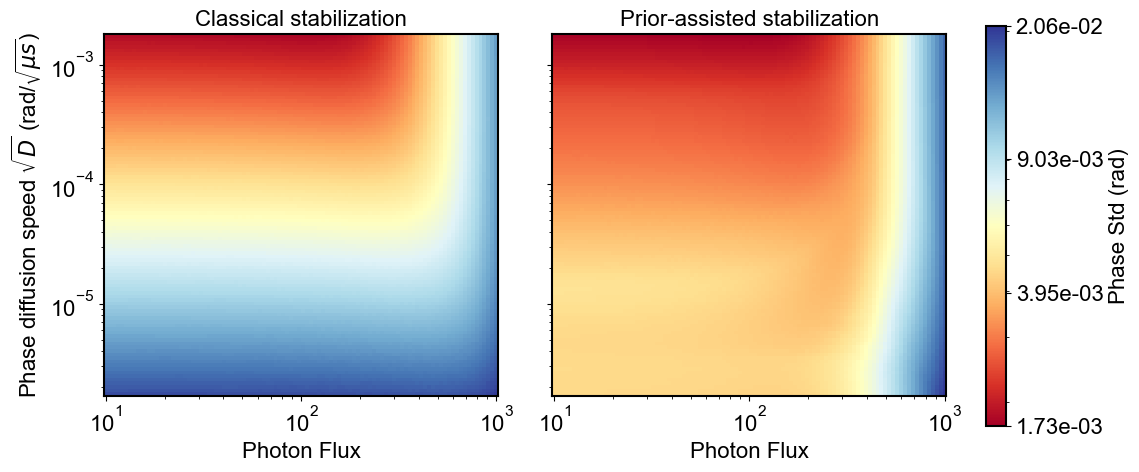

In [26]:
# ============================================================================
# VISUALIZATION: Comparison of Stabilization Methods
# ============================================================================
from matplotlib.colors import Normalize, LogNorm

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create meshgrid for plotting (X: photon flux, Y: phase speed)
X, Y = np.meshgrid(n_dense, phase_speed_list)

# Unify color scale across both plots for fair comparison
vmin = min(np.array(cla_std_array).min(), np.array(ff_std_array).min())
vmax = max(np.array(cla_std_array).max(), np.array(ff_std_array).max())
norm = LogNorm(vmin=vmin, vmax=vmax)  # Logarithmic color scale

# Plot heatmaps: color represents phase stability (std deviation)
# Lower values (blue) = better stability, Higher values (red) = worse stability
pc1 = ax1.pcolormesh(X, Y, cla_std_array, cmap='RdYlBu', norm=norm)
pc2 = ax2.pcolormesh(X, Y, ff_std_array, cmap='RdYlBu', norm=norm)

# Set logarithmic scales for both axes
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

# Labels and titles
ax1.set_title('Classical stabilization')
ax1.set_ylabel(r'Phase diffusion speed $\sqrt{D}$ (rad/$\sqrt{\mu s}$)')

ax2.set_title('Prior-assisted stabilization')
ax2.set_yticklabels("")  # Remove duplicate y-axis labels

ax1.set_xlabel("Photon Flux")
ax2.set_xlabel("Photon Flux")

# Adjust layout to make room for colorbar
fig.subplots_adjust(right=1)
cbar_ax = fig.add_axes([1, 0.12, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(pc1, cax=cbar_ax)
cbar.set_label(r'Phase Std (rad)')

# Set colorbar ticks with readable formatting
ticks = np.logspace(np.log10(vmin), np.log10(vmax), num=4)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{tick:.2e}" for tick in ticks])

plt.tight_layout()
plt.savefig('SM_Fig1_sim_result.pdf', bbox_inches='tight')
plt.show()